# Dane techniczne sprzętu

Obliczenia zostały wykonane na komputerze o następujących parametrach:

- Procesor: AMD Ryzen $7$ $4700$U ($8$ rdzeni, $8$ wątków),

- Pamięć RAM: $16$ GB $3200$ MHz

# Biblioteki

In [1]:
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tabulate import tabulate

In [2]:
# sns.set(rc={"figure.dpi": 200, 'savefig.dpi': 200})

# Pomocnicze funkcje

## Dokładność przybliżenia funkcji interpolowanej przez wielomian interpolujący 

### Wykorzystane wskaźniki

Przyjmijmy następujące oznaczenia:

$f(x)$ - interpolowana funkcja (funkcja wzorcowa)

$W(x)$ - wielomian interpolujący (przybliżający funkcję wzorcową)

#### Norma z różnicy

$||f(x)-W(x)||$

In [3]:
def abs_diff(f, W, xs):
    return [abs(f(x) - W(x)) for x in xs]

#### Największa różnica

$max_k\{||f(x_k)-W(x_k)||\}$

In [4]:
def max_diff(f, W, xs):
    return max(abs_diff(f, W, xs))

#### Suma kwadratów różnic

$\sum\limits_{i = 1}^{N} (f(x_i) - W(x_i))^2$

In [5]:
def sum_sq_diff(f, W, xs):
    return sum(d ** 2 for d in abs_diff(f, W, xs))

### Funkcja służąca do wyznaczania błędów

In [6]:
def interpolation_error(f, Ws, a, b, N, *, prec=6):
    xs = np.linspace(a, b, N)
    
    for W, label in Ws:
        diffs = abs_diff(f, W, xs)
        print(tabulate([
                ('Największy bezwzględny błąd', max(diffs)),
                ('Suma kwadratów różnic      ', sum(x ** 2 for x in diffs))
            ], [
                f'Interpolacja {label}'
            ], tablefmt='fancy_grid', floatfmt=f'.{prec}f')
        )

## Tworzenie wykresu funkcji

### Rysowanie pojedynczej funkcji na wykresie

In [7]:
def plot_fn(fn, a, b, *, label='', title='Wykres', color='b', step=.1, ax=plt):
    n = int((b - a) / step) + 1
    xs = np.linspace(a, b, n)
    ys = np.vectorize(fn)(xs)
    ax.plot(xs, ys, color, label=label)
    if label: ax.legend(loc='best')
    
    if ax is plt:
        ax.title(title)
        ax.xlabel('x')
        ax.ylabel('y')
    else:
        ax.title.set_text(title)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
    ax.grid()
    
    sns.despine()

### Rysowanie kilku funkcji na jednym wykresie

In [8]:
class PlotFn:
    def __init__(self, f, color='b', label=''):
        self.f = f
        self.color = color
        self.label = label

def plot_fns(fns: list[PlotFn], a, b, *, title='Wykres', step=.1, ax=plt):
    for fn_obj in fns:
        plot_fn(fn_obj.f, a, b, title=title, step=step, ax=ax, color=fn_obj.color, label=fn_obj.label)

### Rysowanie wykresów funkcji i błędów

In [9]:
class PlotIntep:
    def __init__(self, interp_method, color='b', label='', args=(), kwargs={}):
        self.im = interp_method
        self.color = color
        self.label = label
        self.args = args
        self.kwargs = kwargs

def rich_plot(fn_obj: 'Funkcja wyjściowa', 
              im_objs: list[PlotIntep],
              a, b, n, *, 
              step=.01, N=1000,
              nodes_calc_method=np.linspace,
              title_comp='Porównanie z wyjściową funkcją', 
              title_err='Błędy interpolacji',
              show_errors_details=False,
              error_prec=6):
    xs = nodes_calc_method(a, b, n)
    ys = np.vectorize(fn_obj.f)(xs)
    W_objs = [PlotFn(obj.im(xs, ys, *obj.args, **obj.kwargs), obj.color, obj.label) for obj in im_objs]
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))
    
    # Compare interpolations to the original function
    fns = [fn_obj] + W_objs
    plot_fns(fns, a, b, title=title_comp, step=step, ax=ax[0])
    ax[0].scatter(xs, ys)
    ax[0].grid(visible=True)
    
    # Create errors plot
    xs_ = np.linspace(a, b, N)
    
    for i, W_obj in enumerate(W_objs):
        diffs = abs_diff(fn_obj.f, W_obj.f, xs_)
        ax[1].scatter(xs_, diffs, s=2, c=im_objs[i].color)
    ax[1].set_title(title_err)
    ax[1].grid(visible=True)
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')
    
    plt.show()
    
    if show_errors_details:
        interpolation_error(fn_obj.f, [(W.f, W.label) for W in W_objs], a, b, N, prec=error_prec)

## Wyznaczanie węzłów zgodnie z zerami wielomianu Czebyszewa

In [10]:
def chebyshev_nodes(a, b, n):
    xs = []
    for k in range(n, 0, -1):
        xs.append(.5 * (a + b) + .5 * (b - a) * math.cos((2 * k - 1) / (2 * n) * math.pi))
    return xs

# Wyznaczanie funkcji sklejanej

## Badana funkcja

In [11]:
f = lambda x, k, m: math.e ** (-k * math.sin(m * x)) + k * math.sin(m * x) - 1

In [12]:
k = 2
m = 2
a = -math.pi
b = 2 * math.pi
x = [a, b]

g = lambda x: f(x, k, m)

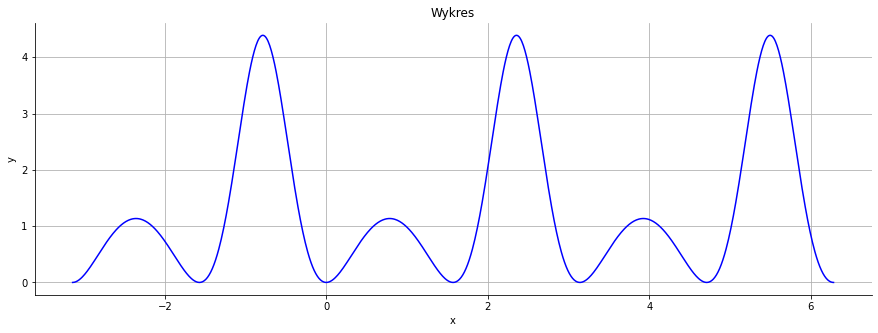

In [13]:
plt.figure(figsize=(15, 5))
plot_fn(g, a, b, step=.01)

## Interpolacja

### $1$. stopnia 
#### (interpolacja liniowa)

In [14]:
def Ψ(x, i, xs):
    if i < 0 or i > len(xs):
        raise ValueError("Wrong i value")
    if i > 0 and xs[i - 1] <= x <= xs[i]:
        return (x - xs[i - 1]) / (xs[i] - xs[i - 1])
    if i < len(xs) and xs[i] < x <= xs[i + 1]:
        return (xs[i + 1] - x) / (xs[i + 1] - xs[i])
    return 0

def binary_search(x, xs):
    l = 0
    r = len(xs) - 1
    
    while l <= r:
        m = (l + r) // 2
        if x > xs[m]:
            l = m + 1
        else:
            r = m - 1
        
    return l

def linear_spline(xs, ys):
    n = len(xs)
    
    def s(x):
        i = binary_search(x, xs)
        y = 0
        if i < n: 
            y += ys[i] * Ψ(x, i, xs)
            if i > 0: y += ys[i - 1] * Ψ(x, i - 1, xs)

        return y
    
    return s

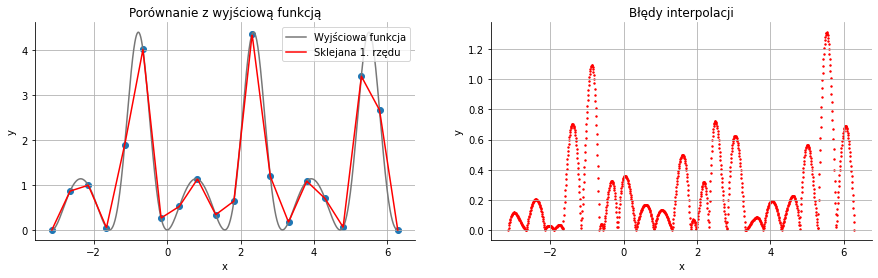

╒═════════════════════════════╤══════════════════════════════════╕
│                             │   Interpolacja Sklejana 1. rzędu │
╞═════════════════════════════╪══════════════════════════════════╡
│ Największy bezwzględny błąd │                         1.312480 │
├─────────────────────────────┼──────────────────────────────────┤
│ Suma kwadratów różnic       │                       153.799861 │
╘═════════════════════════════╧══════════════════════════════════╛


In [15]:
n = 20

rich_plot(
    PlotFn(g, "#777", "Wyjściowa funkcja"), 
    [PlotIntep(linear_spline, 'r', 'Sklejana 1. rzędu')], 
    a, b, n,
    show_errors_details=True
)

### $2$. stopnia 
#### (interpolacja kwadratowa)

In [16]:
import enum

class QuadBoundCond(enum.Enum): 
    NaturalSpline = 0  # Free Bundary
    ClampedBoundary = 1
    
class QuadraticSpline:
    def __init__(self, xs, ys, *, boundary_condition=QuadBoundCond.NaturalSpline):
        self.n = n = len(ys)  # The number of nodes
        self.xs = xs
        self.ys = ys
        self.bc = boundary_condition
        self.fns = []
        self.__solve()
        
    def __call__(self, x):
        i = max(0, min(self.search_range_idx(x), self.n - 2))
        return self.fns[i](x)
    
    def γ(self, i):
        return (self.ys[i] - self.ys[i - 1]) / (self.xs[i] - self.xs[i - 1])
    
    def search_range_idx(self, x):
        xs = self.xs
        l = 0
        r = self.n - 1

        while l <= r:
            m = (l + r) // 2
            if x >= xs[m]:
                l = m + 1
            else:
                r = m - 1

        return l - 1
    
    def __solve(self):
        match self.bc:
            case QuadBoundCond.NaturalSpline:
                self.__solve_with_natural_spline()
            case QuadBoundCond.ClampedBoundary:
                self.__solve_with_clamped_boundary()
        
    def __solve_with_natural_spline(self):
        n = self.n
        a_list = []
        b_list = [0]
        c_list = self.ys
        
        for i in range(1, n):
            b_list.append(2 * self.γ(i) - b_list[-1])

        for i in range(n - 1):
            a_list.append((b_list[i + 1] - b_list[i]) / (2 * (self.xs[i + 1] - self.xs[i])))
        
        self.__calc_functions(a_list, b_list, c_list)

    def __solve_with_clamped_boundary(self):
        n = self.n
        a_list = []
        # f'(x1) = f[x0, x1] = (f(x1) - f(x0)) / (x1 - x0) = (y1 - y0) / (x1 - x0)
        b_list = [(self.ys[1] - self.ys[0]) / (self.xs[1] - self.xs[0]) ** 2]  
        c_list = self.ys
        
        for i in range(1, n):
            b_list.append(2 * self.γ(i) - b_list[-1])

        for i in range(n - 1):
            a_list.append((b_list[i + 1] - b_list[i]) / (2 * (self.xs[i + 1] - self.xs[i])))
        
        self.__calc_functions(a_list, b_list, c_list)
        
    def __calc_functions(self, a_list, b_list, c_list):
        def s(i):
            a = a_list[i]
            b = b_list[i]
            c = c_list[i]
            return lambda x: a * (x - self.xs[i]) ** 2 + b * (x - self.xs[i]) + c
        
        for i in range(self.n - 1):
            self.fns.append(s(i))

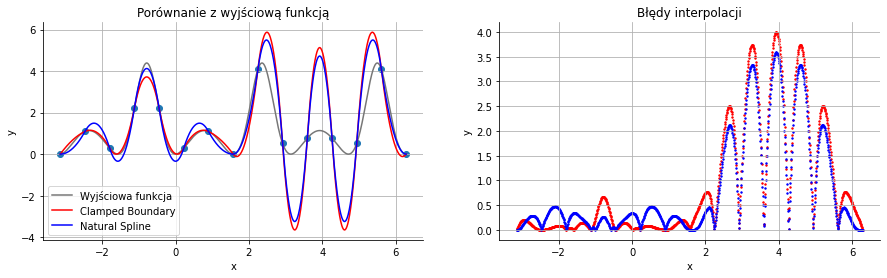

╒═════════════════════════════╤═════════════════════════════════╕
│                             │   Interpolacja Clamped Boundary │
╞═════════════════════════════╪═════════════════════════════════╡
│ Największy bezwzględny błąd │                        3.993597 │
├─────────────────────────────┼─────────────────────────────────┤
│ Suma kwadratów różnic       │                     2168.106036 │
╘═════════════════════════════╧═════════════════════════════════╛
╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Natural Spline │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      3.588034 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                   1685.008177 │
╘═════════════════════════════╧═══════════════════════════════╛


In [17]:
n = 15

qbc = QuadBoundCond

rich_plot(
    PlotFn(g, "#777", "Wyjściowa funkcja"), 
    [
        PlotIntep(QuadraticSpline, 'r', 'Clamped Boundary', kwargs={'boundary_condition': qbc.ClampedBoundary}),
        PlotIntep(QuadraticSpline, 'b', 'Natural Spline', kwargs={'boundary_condition': qbc.NaturalSpline})
    ], 
    a, b, n,
    show_errors_details=True
)

##### $3$. stopnia 
#### (interpolacja sześcienna)

In [18]:
from pprint import pprint as pp
import enum


def det_(A, B=None, substitute_idx=None):
    n = len(A)
    res = 0
    diags = np.ones(3)
    
    for i in range(n):
        if i > 0: diags[0] *= A[i, 0] if i - 1 != substitute_idx else B[i]
        diags[1] *= A[i, 1] if i != substitute_idx else B[i]
        if i < n - 1: diags[2] *= A[i, 2] if i + 1 != substitute_idx else B[i]

    return sum(diags)

def cramer(A, B):
    n = len(A)
    W = det_(A)
    W_ = [det_(A, B, i) for i in range(n)]  # A list of determinants
    return [W_[i] / W for i in range(n)]

def gauss(A, B):
    A = np.array(A, float)
    B = np.array(B, float)
    n = len(A)
    X = np.zeros(n, float)
    
    # Elimination
    for r in range(n - 1):
        if A[r + 1, 0] == 0: continue
        factor = A[r, 1] / A[r + 1, 0]  # main diagonal has idx 1
        for c in range(3 if r < n - 1 else 2):
            A[r + 1, c] = (A[r, c + 1] if c < 2 else 0) - A[r + 1, c] * factor
        B[r + 1] = B[r] - B[r + 1] * factor

    # Back substitution
    X[n - 1] = B[n - 1] / A[n - 1, 1]
    for r in range(n - 2, -1, -1):
        X[r] = (B[r] - A[r, 2] * X[r + 1]) / A[r, 1]

    return X

class CubicBoundCond(enum.Enum):
    CubicFunction = 0
    NaturalSpline = 1 # Free boundary
    ClampedBoundary = 2
    
class CubicSpline:
    def __init__(self, xs, ys, *, boundary_condition=CubicBoundCond.NaturalSpline):
        self.n = n = len(ys)
        self.xs = xs
        self.ys = ys
        self.bc = boundary_condition
        self.fns = []
        self.__solve()
        
    def __call__(self, x):
        i = max(0, min(self.search_range_idx(x), self.n - 2))
        return self.fns[i](x)
        
    def h(self, i):
        return self.xs[i + 1] - self.xs[i]
    
    def Δ(self, i):
        return (self.ys[i + 1] - self.ys[i]) / self.h(i)
    
    def search_range_idx(self, x):
        xs = self.xs
        l = 0
        r = self.n - 1

        while l <= r:
            m = (l + r) // 2
            if x >= xs[m]:
                l = m + 1
            else:
                r = m - 1

        return l - 1
        
    def __solve(self):
        match self.bc:
            case CubicBoundCond.CubicFunction:
                return self.__solve_with_cubic_function()
            case CubicBoundCond.NaturalSpline:
                return self.__solve_with_natural_spline()
            case CubicBoundCond.ClampedBoundary:
                return self.__solve_with_clamped_boundary()
        
    def __solve_with_cubic_function(self):
        n = self.n
        h = self.h
        A = np.zeros((n, 3))
        B = np.zeros(n)
        
        self.__fill_middle_rows(A, B, 0)
        
        ### Apply boundary conditions
        start_xs = self.xs[:4]
        start_ys = self.ys[:4]
        end_xs = self.xs[-4:]
        end_ys = self.ys[-4:]
        Δs1 = self.__differential_quotients(start_xs, start_ys)
        Δs2 = self.__differential_quotients(end_xs, end_ys)
        
        # The first row
        A[0, 1] = -h(0)
        A[0, 2] = h(0)
        B[0] = h(0) ** 2 * Δs1[3]
        
        # The last row
        A[n - 1, 0] = h(n - 2)
        A[n - 1, 1] = -h(n - 2)
        B[n - 1] = -h(n - 2) ** 2 * Δs2[3]
            
        σs = gauss(A, B)  # Modified Gauss Elimination algorithm to solve a system of equations
        self.__calc_functions(*self.__calc_coefficients(σs))
        
    def __solve_with_natural_spline(self):
        n = self.n
        A = np.zeros((n - 2, 3))
        B = np.zeros(n - 2)
        
        self.__fill_middle_rows(A, B, -1)
        A[0, 0] = A[-1, -1] = 0
    
        σs = [0, *gauss(A, B), 0]
        self.__calc_functions(*self.__calc_coefficients(σs))
        
    def __solve_with_clamped_boundary(self):
        n = self.n
        h = self.h
        Δ = self.Δ
        A = np.zeros((n, 3))
        B = np.zeros(n)
        
        self.__fill_middle_rows(A, B, 0)
        
        ### Apply boundary conditions
        # The first row
        A[0, 1] = 2
        A[0, 2] = 1
        deriv_f1 = (self.ys[1] - self.ys[0]) / (self.xs[1] - self.xs[0])
        B[0] = (Δ(1) - deriv_f1) / self.h(1)
        
        # The last row
        A[n - 1, 0] = 2
        A[n - 1, 1] = 1
        deriv_fn = (self.ys[-2] - self.ys[-1]) / (self.xs[-2] - self.xs[-1])
        B[0] = (Δ(n - 2) - deriv_fn) / self.h(n - 2)
        
        σs = gauss(A, B)  # Modified Gauss Elimination algorithm to solve a system of equations
        self.__calc_functions(*self.__calc_coefficients(σs))
        
    def __fill_middle_rows(self, A, B, offset):
        for i in range(1, self.n - 1):
            A[i + offset, 0] = self.h(i - 1)
            A[i + offset, 1] = 2 * (self.h(i - 1) + self.h(i))
            A[i + offset, 2] = self.h(i)
            B[i + offset] = self.Δ(i) - self.Δ(i - 1)
        
    def __calc_coefficients(self, σs):
        a_list = []
        b_list = []
        c_list = []
        d_list = self.ys
        
        for i in range(self.n - 1):
            a_list.append((σs[i + 1] - σs[i]) / self.h(i))
            b_list.append(3 * σs[i])
            c_list.append((self.ys[i + 1] - self.ys[i]) / self.h(i) - self.h(i) * (σs[i + 1] + 2 * σs[i]))
        
        return a_list, b_list, c_list, d_list
        
    def __calc_functions(self, a_list, b_list, c_list, d_list):
        for i in range(self.n - 1):
            def s(i):
                a = a_list[i]
                b = b_list[i]
                c = c_list[i]
                d = d_list[i]
            
                def f(x):
                    diff = x - self.xs[i]
                    return a * diff**3 + b * diff**2 + c * diff + d
                return f
            
            self.fns.append(s(i))

    @staticmethod
    def __differential_quotients(xs, ys):
        n = len(xs)
        Δs = list(ys)
        
        for j in range(1, n):
            for i in range(n - 1, j - 1, -1):
                Δs[i] = (Δs[i] - Δs[i - 1]) / (xs[i] - xs[i - j])
                
        return Δs

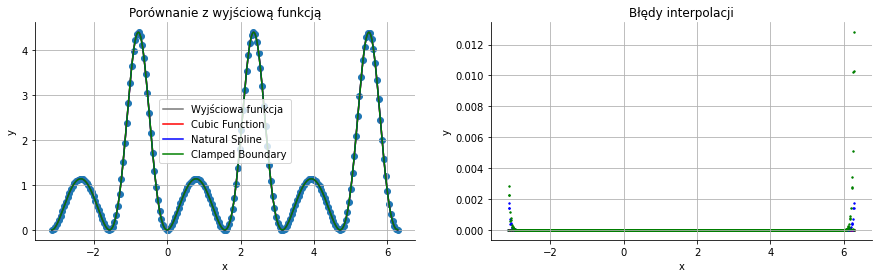

╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Cubic Function │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      0.000022 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                      0.000000 │
╘═════════════════════════════╧═══════════════════════════════╛
╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Natural Spline │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      0.001759 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                      0.000016 │
╘═════════════════════════════╧═══════════════════════════════╛
╒═════════════════════════════╤═════════════════════════════════╕
│                             │   Inte

In [19]:
n = 200

from scipy import interpolate

rich_plot(
    PlotFn(g, "#777", "Wyjściowa funkcja"), 
    [
        PlotIntep(CubicSpline, 'r', 'Cubic Function', kwargs={'boundary_condition': CubicBoundCond.CubicFunction}),
        PlotIntep(CubicSpline, 'b', 'Natural Spline', kwargs={'boundary_condition': CubicBoundCond.NaturalSpline}),
        PlotIntep(CubicSpline, 'g', 'Clamped Boundary', kwargs={'boundary_condition': CubicBoundCond.ClampedBoundary}),
    ],
    a, b, n,
    show_errors_details=True
)

###### Porównanie z biblioteką `scipy`

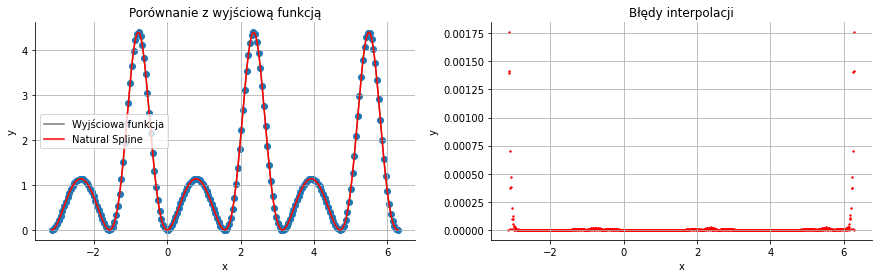

╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Natural Spline │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      0.001759 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                      0.000016 │
╘═════════════════════════════╧═══════════════════════════════╛


In [20]:
from scipy.interpolate import CubicSpline as CS

n = 200

rich_plot(
    PlotFn(g, "#777", "Wyjściowa funkcja"), 
    [PlotIntep(CS, 'r', 'Natural Spline', kwargs={'bc_type': 'natural'})], 
    a, b, n,
    show_errors_details=True
)

## Interpolacja dla różnej liczby węzłów

### Funkcja sklejana $2$. stopnia

#### Dla $3$, $4$ lub $7$ węzłów
(Zachowuje się tak samo, jak wcześniej poznane metody interpolacji)

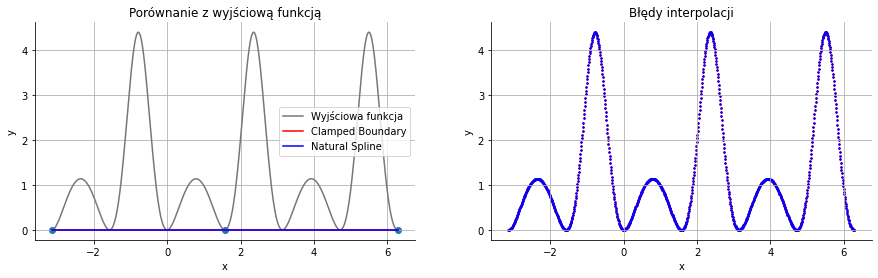

╒═════════════════════════════╤═════════════════════════════════╕
│                             │   Interpolacja Clamped Boundary │
╞═════════════════════════════╪═════════════════════════════════╡
│ Największy bezwzględny błąd │                        4.388914 │
├─────────────────────────────┼─────────────────────────────────┤
│ Suma kwadratów różnic       │                     3376.823725 │
╘═════════════════════════════╧═════════════════════════════════╛
╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Natural Spline │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      4.388914 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                   3376.823725 │
╘═════════════════════════════╧═══════════════════════════════╛


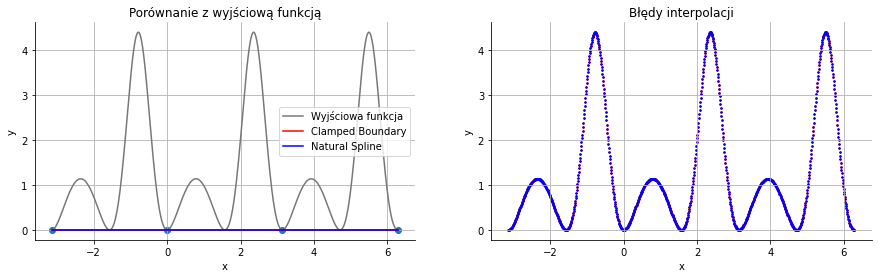

╒═════════════════════════════╤═════════════════════════════════╕
│                             │   Interpolacja Clamped Boundary │
╞═════════════════════════════╪═════════════════════════════════╡
│ Największy bezwzględny błąd │                        4.388914 │
├─────────────────────────────┼─────────────────────────────────┤
│ Suma kwadratów różnic       │                     3376.823725 │
╘═════════════════════════════╧═════════════════════════════════╛
╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Natural Spline │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      4.388914 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                   3376.823725 │
╘═════════════════════════════╧═══════════════════════════════╛


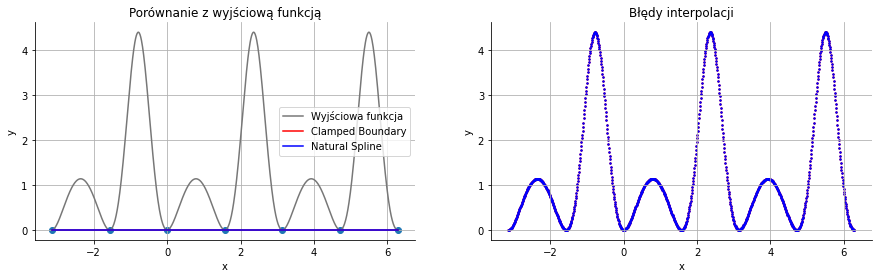

╒═════════════════════════════╤═════════════════════════════════╕
│                             │   Interpolacja Clamped Boundary │
╞═════════════════════════════╪═════════════════════════════════╡
│ Największy bezwzględny błąd │                        4.388914 │
├─────────────────────────────┼─────────────────────────────────┤
│ Suma kwadratów różnic       │                     3376.823725 │
╘═════════════════════════════╧═════════════════════════════════╛
╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Natural Spline │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      4.388914 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                   3376.823725 │
╘═════════════════════════════╧═══════════════════════════════╛


In [21]:
for n in {3, 4, 7}:
    rich_plot(
        PlotFn(g, "#777", "Wyjściowa funkcja"), 
        [
            PlotIntep(QuadraticSpline, 'r', 'Clamped Boundary', kwargs={'boundary_condition': QuadBoundCond.ClampedBoundary}),
            PlotIntep(QuadraticSpline, 'b', 'Natural Spline', kwargs={'boundary_condition': QuadBoundCond.NaturalSpline})
        ], 
        a, b, n,
        show_errors_details=True
    )

#### Dla $5$ węzłów

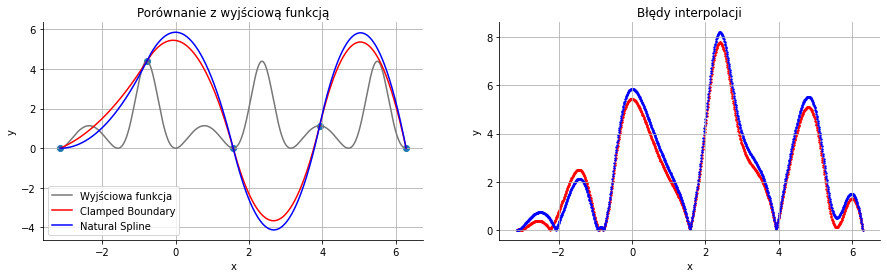

╒═════════════════════════════╤═════════════════════════════════╕
│                             │   Interpolacja Clamped Boundary │
╞═════════════════════════════╪═════════════════════════════════╡
│ Największy bezwzględny błąd │                        7.781749 │
├─────────────────────────────┼─────────────────────────────────┤
│ Suma kwadratów różnic       │                    10217.836053 │
╘═════════════════════════════╧═════════════════════════════════╛
╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Natural Spline │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      8.204672 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                  11876.666172 │
╘═════════════════════════════╧═══════════════════════════════╛


In [22]:
n = 5

rich_plot(
    PlotFn(g, "#777", "Wyjściowa funkcja"), 
    [
        PlotIntep(QuadraticSpline, 'r', 'Clamped Boundary', kwargs={'boundary_condition': QuadBoundCond.ClampedBoundary}),
        PlotIntep(QuadraticSpline, 'b', 'Natural Spline', kwargs={'boundary_condition': QuadBoundCond.NaturalSpline})
    ], 
    a, b, n,
    show_errors_details=True
)

#### Dla $10$ węzłów

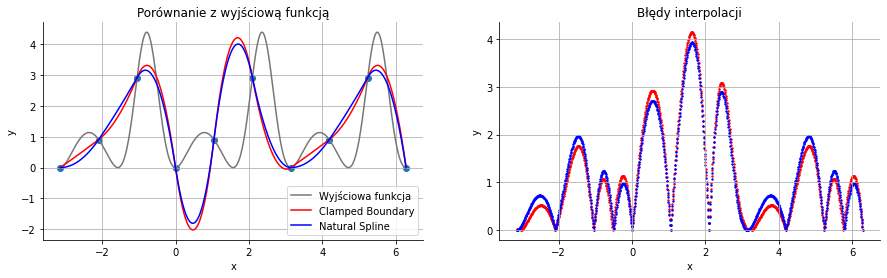

╒═════════════════════════════╤═════════════════════════════════╕
│                             │   Interpolacja Clamped Boundary │
╞═════════════════════════════╪═════════════════════════════════╡
│ Największy bezwzględny błąd │                        4.149815 │
├─────────────────────────────┼─────────────────────────────────┤
│ Suma kwadratów różnic       │                     2353.005136 │
╘═════════════════════════════╧═════════════════════════════════╛
╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Natural Spline │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      3.935790 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                   2240.645190 │
╘═════════════════════════════╧═══════════════════════════════╛


In [23]:
n = 10

rich_plot(
    PlotFn(g, "#777", "Wyjściowa funkcja"), 
    [
        PlotIntep(QuadraticSpline, 'r', 'Clamped Boundary', kwargs={'boundary_condition': QuadBoundCond.ClampedBoundary}),
        PlotIntep(QuadraticSpline, 'b', 'Natural Spline', kwargs={'boundary_condition': QuadBoundCond.NaturalSpline})
    ], 
    a, b, n,
    show_errors_details=True
)

#### Dla $15$ węzłów

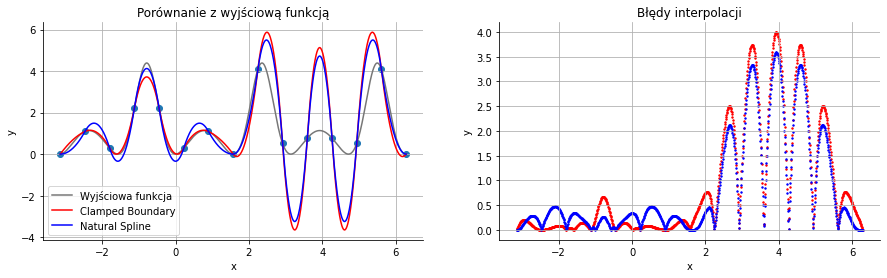

╒═════════════════════════════╤═════════════════════════════════╕
│                             │   Interpolacja Clamped Boundary │
╞═════════════════════════════╪═════════════════════════════════╡
│ Największy bezwzględny błąd │                        3.993597 │
├─────────────────────────────┼─────────────────────────────────┤
│ Suma kwadratów różnic       │                     2168.106036 │
╘═════════════════════════════╧═════════════════════════════════╛
╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Natural Spline │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      3.588034 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                   1685.008177 │
╘═════════════════════════════╧═══════════════════════════════╛


In [24]:
n = 15

rich_plot(
    PlotFn(g, "#777", "Wyjściowa funkcja"), 
    [
        PlotIntep(QuadraticSpline, 'r', 'Clamped Boundary', kwargs={'boundary_condition': QuadBoundCond.ClampedBoundary}),
        PlotIntep(QuadraticSpline, 'b', 'Natural Spline', kwargs={'boundary_condition': QuadBoundCond.NaturalSpline})
    ], 
    a, b, n,
    show_errors_details=True
)

#### Dla $25$ węzłów

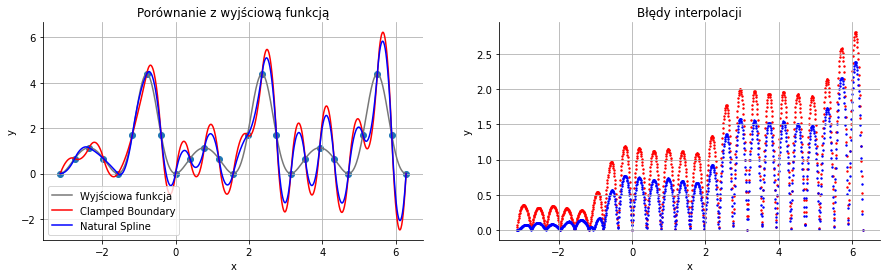

╒═════════════════════════════╤═════════════════════════════════╕
│                             │   Interpolacja Clamped Boundary │
╞═════════════════════════════╪═════════════════════════════════╡
│ Największy bezwzględny błąd │                        2.812735 │
├─────────────────────────────┼─────────────────────────────────┤
│ Suma kwadratów różnic       │                     1253.590177 │
╘═════════════════════════════╧═════════════════════════════════╛
╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Natural Spline │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      2.394300 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                    747.851694 │
╘═════════════════════════════╧═══════════════════════════════╛


In [25]:
n = 25

rich_plot(
    PlotFn(g, "#777", "Wyjściowa funkcja"), 
    [
        PlotIntep(QuadraticSpline, 'r', 'Clamped Boundary', kwargs={'boundary_condition': QuadBoundCond.ClampedBoundary}),
        PlotIntep(QuadraticSpline, 'b', 'Natural Spline', kwargs={'boundary_condition': QuadBoundCond.NaturalSpline})
    ], 
    a, b, n,
    show_errors_details=True
)

#### Dla $35$ węzłów

Jak widzimy, wraz ze wzrostem liczby węzłów, majele błąd przybliżenia, ale równocześnie, coraz bardziej uwidacznia się różnica w dokładności przybliżenia między funkcją, do obliczenia której wykorzystaliśmy warunek brzegowy *Clamped Boundary* a funkcją obliczoną, z wykorzystaniem warunku brzegowego *Natural Spline*. Widać to także w tabeli zamieszczonej pod wykresami, która pokazuje rosnący stosunek błędu interpolacji z warunkiem *Natural Spline* do błędu interpolacji z warunkiem *Clamped Boundary*.

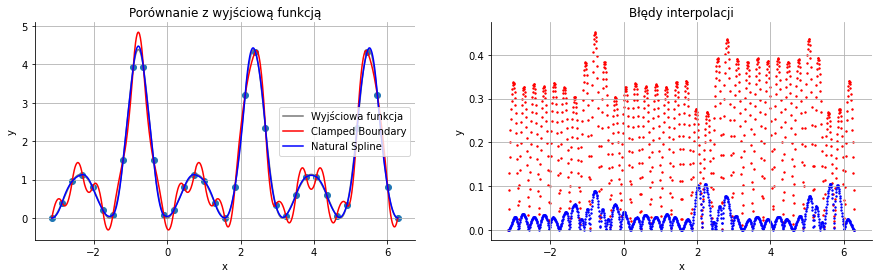

╒═════════════════════════════╤═════════════════════════════════╕
│                             │   Interpolacja Clamped Boundary │
╞═════════════════════════════╪═════════════════════════════════╡
│ Największy bezwzględny błąd │                        0.451390 │
├─────────────────────────────┼─────────────────────────────────┤
│ Suma kwadratów różnic       │                       66.697220 │
╘═════════════════════════════╧═════════════════════════════════╛
╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Natural Spline │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      0.105274 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                      1.432820 │
╘═════════════════════════════╧═══════════════════════════════╛


In [26]:
n = 35

rich_plot(
    PlotFn(g, "#777", "Wyjściowa funkcja"), 
    [
        PlotIntep(QuadraticSpline, 'r', 'Clamped Boundary', kwargs={'boundary_condition': QuadBoundCond.ClampedBoundary}),
        PlotIntep(QuadraticSpline, 'b', 'Natural Spline', kwargs={'boundary_condition': QuadBoundCond.NaturalSpline})
    ], 
    a, b, n,
    show_errors_details=True
)

#### Dla $50$ węzłów

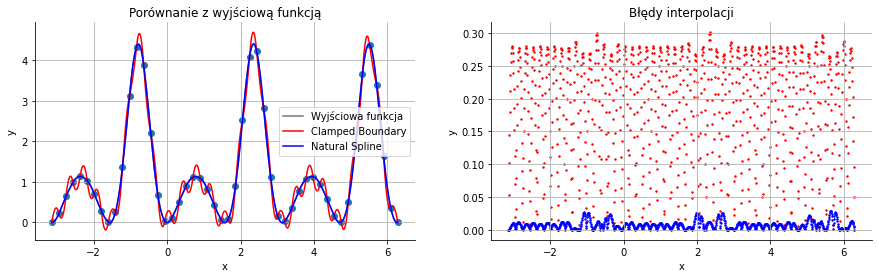

╒═════════════════════════════╤═════════════════════════════════╕
│                             │   Interpolacja Clamped Boundary │
╞═════════════════════════════╪═════════════════════════════════╡
│ Największy bezwzględny błąd │                        0.301210 │
├─────────────────────────────┼─────────────────────────────────┤
│ Suma kwadratów różnic       │                       41.679781 │
╘═════════════════════════════╧═════════════════════════════════╛
╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Natural Spline │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      0.029001 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                      0.097222 │
╘═════════════════════════════╧═══════════════════════════════╛


In [27]:
n = 50

rich_plot(
    PlotFn(g, "#777", "Wyjściowa funkcja"), 
    [
        PlotIntep(QuadraticSpline, 'r', 'Clamped Boundary', kwargs={'boundary_condition': QuadBoundCond.ClampedBoundary}),
        PlotIntep(QuadraticSpline, 'b', 'Natural Spline', kwargs={'boundary_condition': QuadBoundCond.NaturalSpline})
    ], 
    a, b, n,
    show_errors_details=True
)

#### Dla $100$ węzłów

Powstaje piękny wzorek 😮.

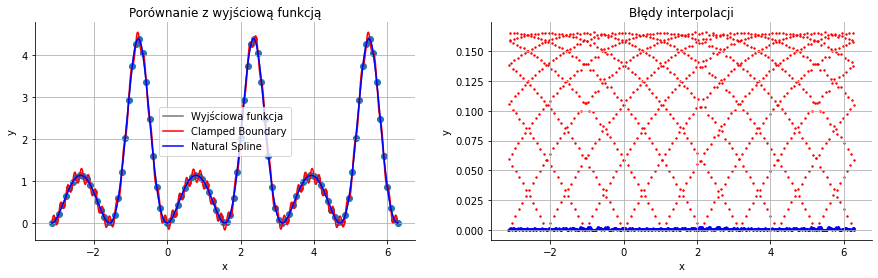

╒═════════════════════════════╤═════════════════════════════════╕
│                             │   Interpolacja Clamped Boundary │
╞═════════════════════════════╪═════════════════════════════════╡
│ Największy bezwzględny błąd │                        0.166052 │
├─────────────────────────────┼─────────────────────────────────┤
│ Suma kwadratów różnic       │                       14.556447 │
╘═════════════════════════════╧═════════════════════════════════╛
╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Natural Spline │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      0.002636 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                      0.001055 │
╘═════════════════════════════╧═══════════════════════════════╛


In [28]:
n = 100

rich_plot(
    PlotFn(g, "#777", "Wyjściowa funkcja"), 
    [
        PlotIntep(QuadraticSpline, 'r', 'Clamped Boundary', kwargs={'boundary_condition': QuadBoundCond.ClampedBoundary}),
        PlotIntep(QuadraticSpline, 'b', 'Natural Spline', kwargs={'boundary_condition': QuadBoundCond.NaturalSpline})
    ], 
    a, b, n,
    show_errors_details=True
)

#### Dla $500$ węzłów

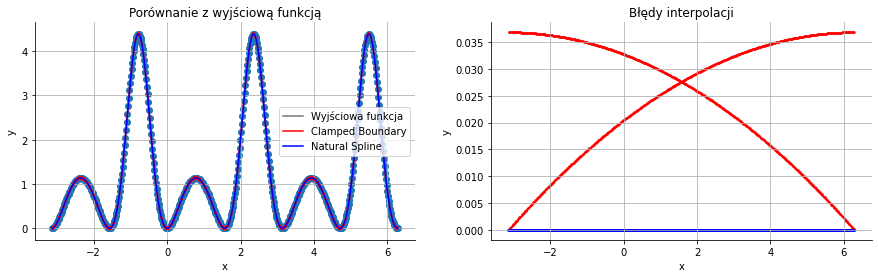

╒═════════════════════════════╤═════════════════════════════════╕
│                             │   Interpolacja Clamped Boundary │
╞═════════════════════════════╪═════════════════════════════════╡
│ Największy bezwzględny błąd │                        0.036815 │
├─────────────────────────────┼─────────────────────────────────┤
│ Suma kwadratów różnic       │                        0.722119 │
╘═════════════════════════════╧═════════════════════════════════╛
╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Natural Spline │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      0.000019 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                      0.000000 │
╘═════════════════════════════╧═══════════════════════════════╛


In [29]:
n = 500

rich_plot(
    PlotFn(g, "#777", "Wyjściowa funkcja"), 
    [
        PlotIntep(QuadraticSpline, 'r', 'Clamped Boundary', kwargs={'boundary_condition': QuadBoundCond.ClampedBoundary}),
        PlotIntep(QuadraticSpline, 'b', 'Natural Spline', kwargs={'boundary_condition': QuadBoundCond.NaturalSpline})
    ], 
    a, b, n,
    show_errors_details=True
)

#### Dla $10000$ węzłów

Jak widać, nawet dla $10000$ węzłów, interpolacja funkcją sklejaną 2. rzędu, wykorzystującą warunek brzegowy *Clamped Boundary*, skutkuje otrzymaniem przybliżenia w dość dużym stopniu obarczonego błędem.

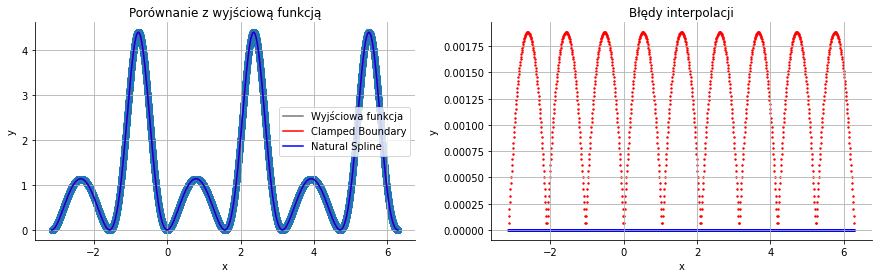

╒═════════════════════════════╤═════════════════════════════════╕
│                             │   Interpolacja Clamped Boundary │
╞═════════════════════════════╪═════════════════════════════════╡
│ Największy bezwzględny błąd │              0.0018826210407945 │
├─────────────────────────────┼─────────────────────────────────┤
│ Suma kwadratów różnic       │              0.0018886893432718 │
╘═════════════════════════════╧═════════════════════════════════╛
╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Natural Spline │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │            0.0000000017872255 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │            0.0000000000000007 │
╘═════════════════════════════╧═══════════════════════════════╛


In [52]:
n = 10000

rich_plot(
    PlotFn(g, "#777", "Wyjściowa funkcja"), 
    [
        PlotIntep(QuadraticSpline, 'r', 'Clamped Boundary', kwargs={'boundary_condition': QuadBoundCond.ClampedBoundary}),
        PlotIntep(QuadraticSpline, 'b', 'Natural Spline', kwargs={'boundary_condition': QuadBoundCond.NaturalSpline})
    ], 
    a, b, n,
    show_errors_details=True,
    error_prec=16
)

### Funkcja sklejana $3$. stopnia

#### Dla $3$ węzłów
(Zachowuje się tak samo, jak wcześniej poznane metody interpolacji)

Nie możemy przeprowadzić interpolacji dla 3 węzłów, wykorzystując warunek brzegowy *Cubic Function*, ponieważ wymaga on, aby istniały przynajmniej 4 węzły interpolacyjne.

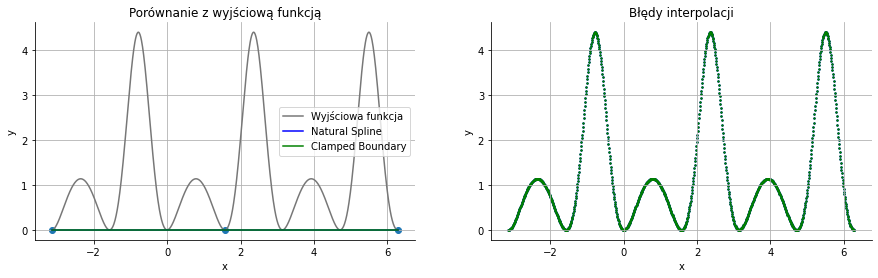

╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Natural Spline │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      4.388914 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                   3376.823725 │
╘═════════════════════════════╧═══════════════════════════════╛
╒═════════════════════════════╤═════════════════════════════════╕
│                             │   Interpolacja Clamped Boundary │
╞═════════════════════════════╪═════════════════════════════════╡
│ Największy bezwzględny błąd │                        4.388914 │
├─────────────────────────────┼─────────────────────────────────┤
│ Suma kwadratów różnic       │                     3376.823725 │
╘═════════════════════════════╧═════════════════════════════════╛


In [31]:
n = 3
rich_plot(
    PlotFn(g, "#777", "Wyjściowa funkcja"), 
    [
        PlotIntep(CubicSpline, 'b', 'Natural Spline', kwargs={'boundary_condition': CubicBoundCond.NaturalSpline}),
        PlotIntep(CubicSpline, 'g', 'Clamped Boundary', kwargs={'boundary_condition': CubicBoundCond.ClampedBoundary})
    ], 
    a, b, n,
    show_errors_details=True
)

#### Dla $4$ i $7$ węzłów
(Zachowuje się tak samo, jak wcześniej poznane metody interpolacji)

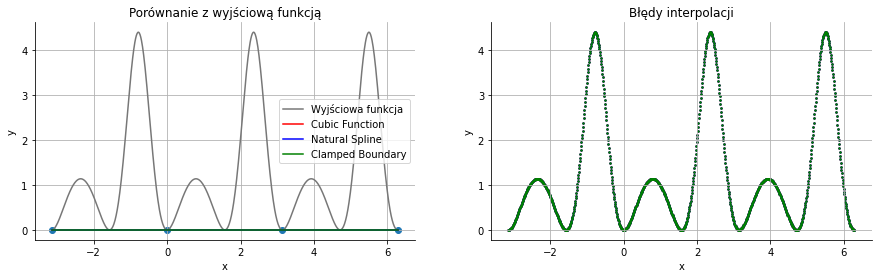

╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Cubic Function │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      4.388914 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                   3376.823725 │
╘═════════════════════════════╧═══════════════════════════════╛
╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Natural Spline │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      4.388914 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                   3376.823725 │
╘═════════════════════════════╧═══════════════════════════════╛
╒═════════════════════════════╤═════════════════════════════════╕
│                             │   Inte

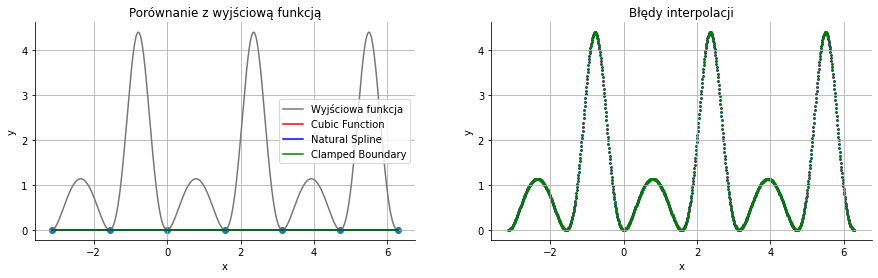

╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Cubic Function │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      4.388914 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                   3376.823725 │
╘═════════════════════════════╧═══════════════════════════════╛
╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Natural Spline │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      4.388914 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                   3376.823725 │
╘═════════════════════════════╧═══════════════════════════════╛
╒═════════════════════════════╤═════════════════════════════════╕
│                             │   Inte

In [32]:
for n in (4, 7):
    rich_plot(
        PlotFn(g, "#777", "Wyjściowa funkcja"), 
        [
            PlotIntep(CubicSpline, 'r', 'Cubic Function', kwargs={'boundary_condition': CubicBoundCond.CubicFunction}),
            PlotIntep(CubicSpline, 'b', 'Natural Spline', kwargs={'boundary_condition': CubicBoundCond.NaturalSpline}),
            PlotIntep(CubicSpline, 'g', 'Clamped Boundary', kwargs={'boundary_condition': CubicBoundCond.ClampedBoundary})
        ], 
        a, b, n,
        show_errors_details=True
    )

#### Dla $5$ węzłów

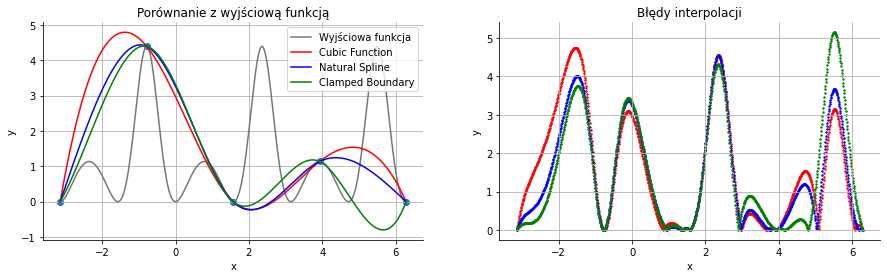

╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Cubic Function │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      4.750091 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                   4510.806769 │
╘═════════════════════════════╧═══════════════════════════════╛
╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Natural Spline │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      4.545972 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                   3912.486322 │
╘═════════════════════════════╧═══════════════════════════════╛
╒═════════════════════════════╤═════════════════════════════════╕
│                             │   Inte

In [33]:
n = 5
rich_plot(
    PlotFn(g, "#777", "Wyjściowa funkcja"), 
    [
        PlotIntep(CubicSpline, 'r', 'Cubic Function', kwargs={'boundary_condition': CubicBoundCond.CubicFunction}),
        PlotIntep(CubicSpline, 'b', 'Natural Spline', kwargs={'boundary_condition': CubicBoundCond.NaturalSpline}),
        PlotIntep(CubicSpline, 'g', 'Clamped Boundary', kwargs={'boundary_condition': CubicBoundCond.ClampedBoundary})
    ], 
    a, b, n,
    show_errors_details=True
)

#### Dla $10$ węzłów

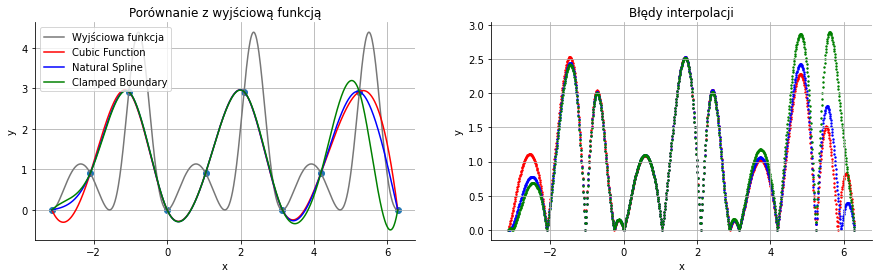

╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Cubic Function │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      2.528188 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                   1534.343919 │
╘═════════════════════════════╧═══════════════════════════════╛
╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Natural Spline │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      2.526951 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                   1534.922606 │
╘═════════════════════════════╧═══════════════════════════════╛
╒═════════════════════════════╤═════════════════════════════════╕
│                             │   Inte

In [34]:
n = 10
rich_plot(
    PlotFn(g, "#777", "Wyjściowa funkcja"), 
    [
        PlotIntep(CubicSpline, 'r', 'Cubic Function', kwargs={'boundary_condition': CubicBoundCond.CubicFunction}),
        PlotIntep(CubicSpline, 'b', 'Natural Spline', kwargs={'boundary_condition': CubicBoundCond.NaturalSpline}),
        PlotIntep(CubicSpline, 'g', 'Clamped Boundary', kwargs={'boundary_condition': CubicBoundCond.ClampedBoundary})
    ], 
    a, b, n,
    show_errors_details=True
)

#### Dla $15$ węzłów

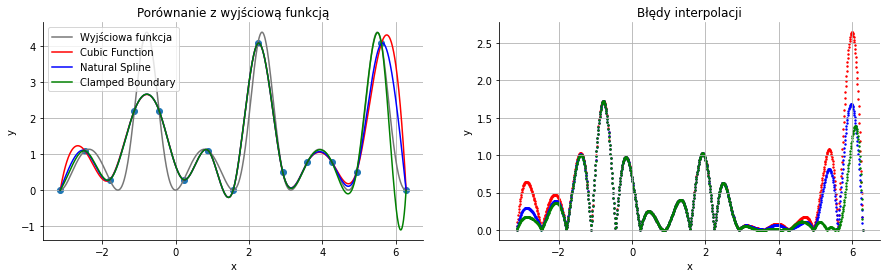

╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Cubic Function │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      2.643170 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                    534.896140 │
╘═════════════════════════════╧═══════════════════════════════╛
╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Natural Spline │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      1.723362 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                    353.138606 │
╘═════════════════════════════╧═══════════════════════════════╛
╒═════════════════════════════╤═════════════════════════════════╕
│                             │   Inte

In [35]:
n = 15
rich_plot(
    PlotFn(g, "#777", "Wyjściowa funkcja"), 
    [
        PlotIntep(CubicSpline, 'r', 'Cubic Function', kwargs={'boundary_condition': CubicBoundCond.CubicFunction}),
        PlotIntep(CubicSpline, 'b', 'Natural Spline', kwargs={'boundary_condition': CubicBoundCond.NaturalSpline}),
        PlotIntep(CubicSpline, 'g', 'Clamped Boundary', kwargs={'boundary_condition': CubicBoundCond.ClampedBoundary})
    ], 
    a, b, n,
    show_errors_details=True
)

#### Dla $25$ węzłów

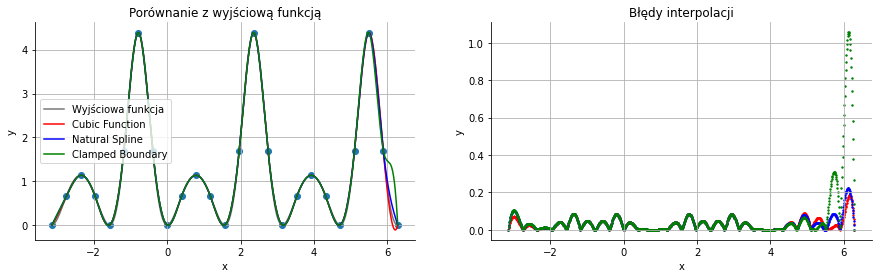

╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Cubic Function │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      0.184047 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                      1.928070 │
╘═════════════════════════════╧═══════════════════════════════╛
╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Natural Spline │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      0.222417 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                      2.504908 │
╘═════════════════════════════╧═══════════════════════════════╛
╒═════════════════════════════╤═════════════════════════════════╕
│                             │   Inte

In [58]:
n = 25
rich_plot(
    PlotFn(g, "#777", "Wyjściowa funkcja"), 
    [
        PlotIntep(CubicSpline, 'r', 'Cubic Function', kwargs={'boundary_condition': CubicBoundCond.CubicFunction}),
        PlotIntep(CubicSpline, 'b', 'Natural Spline', kwargs={'boundary_condition': CubicBoundCond.NaturalSpline}),
        PlotIntep(CubicSpline, 'g', 'Clamped Boundary', kwargs={'boundary_condition': CubicBoundCond.ClampedBoundary})
    ], 
    a, b, n,
    show_errors_details=True
)

#### Dla $35$ węzłów

Możemy zauważyć, że funkcja, która korzysta z warunku brzegowego *Cubic Function*, przybliża znacznie gorzej interpolowaną funkcję niż funkcja korzystająca z warunku brzegowego *Natural Spline*.

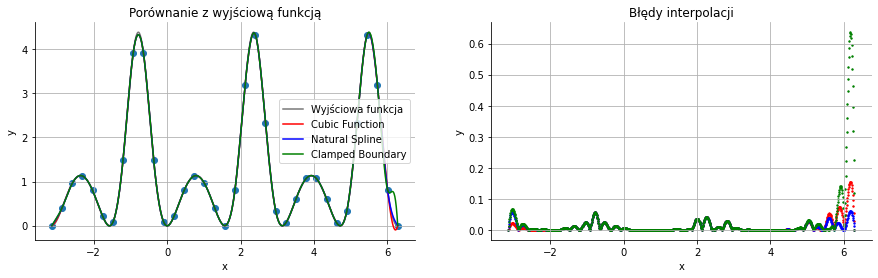

╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Cubic Function │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      0.154643 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                      0.612466 │
╘═════════════════════════════╧═══════════════════════════════╛
╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Natural Spline │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      0.060326 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                      0.261365 │
╘═════════════════════════════╧═══════════════════════════════╛
╒═════════════════════════════╤═════════════════════════════════╕
│                             │   Inte

In [37]:
n = 35
rich_plot(
    PlotFn(g, "#777", "Wyjściowa funkcja"), 
    [
        PlotIntep(CubicSpline, 'r', 'Cubic Function', kwargs={'boundary_condition': CubicBoundCond.CubicFunction}),
        PlotIntep(CubicSpline, 'b', 'Natural Spline', kwargs={'boundary_condition': CubicBoundCond.NaturalSpline}),
        PlotIntep(CubicSpline, 'g', 'Clamped Boundary', kwargs={'boundary_condition': CubicBoundCond.ClampedBoundary})
    ], 
    a, b, n,
    show_errors_details=True
)

#### Dla $50$ węzłów

Dla 50 węzłów widzimy efekt Runge'go w przypadku obu warunków brzegowych, związany z niedokładnością przybliżenia na krańcach przedziału.

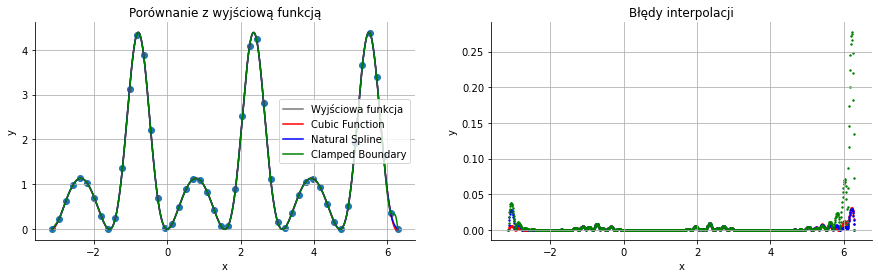

╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Cubic Function │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      0.031019 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                      0.015379 │
╘═════════════════════════════╧═══════════════════════════════╛
╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Natural Spline │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      0.029274 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                      0.021664 │
╘═════════════════════════════╧═══════════════════════════════╛
╒═════════════════════════════╤═════════════════════════════════╕
│                             │   Inte

In [38]:
n = 50
rich_plot(
    PlotFn(g, "#777", "Wyjściowa funkcja"), 
    [
        PlotIntep(CubicSpline, 'r', 'Cubic Function', kwargs={'boundary_condition': CubicBoundCond.CubicFunction}),
        PlotIntep(CubicSpline, 'b', 'Natural Spline', kwargs={'boundary_condition': CubicBoundCond.NaturalSpline}),
        PlotIntep(CubicSpline, 'g', 'Clamped Boundary', kwargs={'boundary_condition': CubicBoundCond.ClampedBoundary})
    ], 
    a, b, n,
    show_errors_details=True
)

Jak możemy zobaczyć poniżej, efekt Rungego został zniwelizowany dla 50 węzłow Czebyszewa, jednak błąd przybliżenia funkcji wewnątrz przedziału wzrósł.

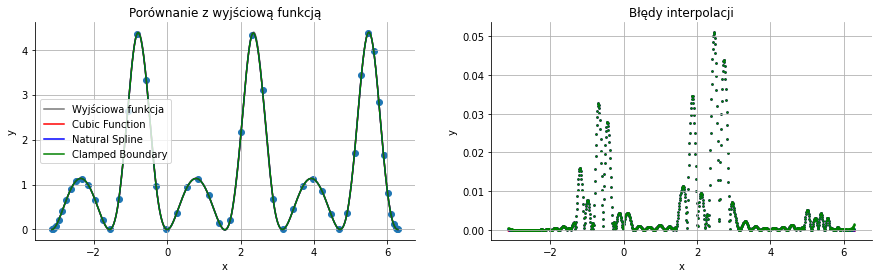

╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Cubic Function │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      0.051018 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                      0.116399 │
╘═════════════════════════════╧═══════════════════════════════╛
╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Natural Spline │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      0.051018 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                      0.116400 │
╘═════════════════════════════╧═══════════════════════════════╛
╒═════════════════════════════╤═════════════════════════════════╕
│                             │   Inte

In [39]:
n = 50
rich_plot(
    PlotFn(g, "#777", "Wyjściowa funkcja"), 
    [
        PlotIntep(CubicSpline, 'r', 'Cubic Function', kwargs={'boundary_condition': CubicBoundCond.CubicFunction}),
        PlotIntep(CubicSpline, 'b', 'Natural Spline', kwargs={'boundary_condition': CubicBoundCond.NaturalSpline}),
        PlotIntep(CubicSpline, 'g', 'Clamped Boundary', kwargs={'boundary_condition': CubicBoundCond.ClampedBoundary})
    ], 
    a, b, n,
    show_errors_details=True,
    nodes_calc_method=chebyshev_nodes
)

##### Dla $100$ węzłów

Jak możemy zobaczyć niżej, wykorzystanie węzłów Czebyszewa pozwala zmniejszyć efekt Rungego oraz błąd przybliżenia interpolowanej funkcji. Z zamieszczonej pod wykresami tabeli wynika jednak, że większy błąd osiąga funkcja, korzystająca z warunku brzegowego *Natural Spline*.

=================================== Równomierny rozkład punktów ====================================



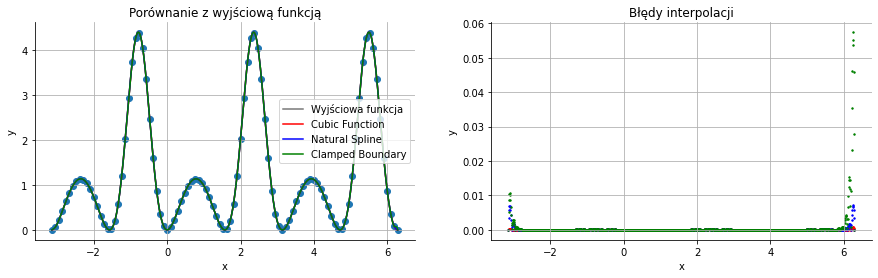

╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Cubic Function │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      0.000799 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                      0.000012 │
╘═════════════════════════════╧═══════════════════════════════╛
╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Natural Spline │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      0.007123 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                      0.000541 │
╘═════════════════════════════╧═══════════════════════════════╛
╒═════════════════════════════╤═════════════════════════════════╕
│                             │   Inte

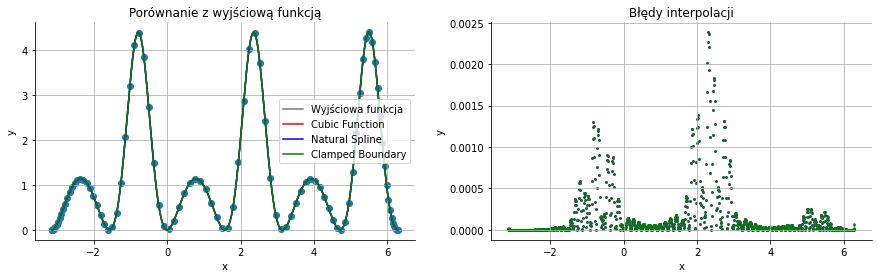

╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Cubic Function │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      0.002386 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                      0.000141 │
╘═════════════════════════════╧═══════════════════════════════╛
╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Natural Spline │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      0.002386 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                      0.000141 │
╘═════════════════════════════╧═══════════════════════════════╛
╒═════════════════════════════╤═════════════════════════════════╕
│                             │   Inte

In [40]:
n = 100
for label, nodes_calc_method in (('Równomierny rozkład punktów', np.linspace), ('Węzły Czebyszewa', chebyshev_nodes)):
    print(f' {label} '.center(100, '='), end='\n\n')
    rich_plot(
        PlotFn(g, "#777", "Wyjściowa funkcja"), 
        [
            PlotIntep(CubicSpline, 'r', 'Cubic Function', kwargs={'boundary_condition': CubicBoundCond.CubicFunction}),
            PlotIntep(CubicSpline, 'b', 'Natural Spline', kwargs={'boundary_condition': CubicBoundCond.NaturalSpline}),
            PlotIntep(CubicSpline, 'g', 'Clamped Boundary', kwargs={'boundary_condition': CubicBoundCond.ClampedBoundary})
        ], 
        a, b, n,
        show_errors_details=True,
        nodes_calc_method=nodes_calc_method
    )
    print('\n\n')

Zobaczmy, jak się zachowuje tylko funkcja, korzystająca z warunku brzegowego *Cubic Function*. Jak widać na poniższym wykresie, nawet dla równomiernego rozmieszczenia punktów, otrzymujemy bardzo dobre przybliżenie. Co ciekawe, korzystając z warunku brzegowego *Cubic Function*, otrzymujemy nawet lepsze przybliżenie dla węzłów równomiernie rozmieszczonych niż dla węzłów Czebyszewa, co pokazują powyższe tabele. Zatem, problem efektu Runge'go dotyczy jedynie funkcji sklejanej 3. stopnia, korzystającej z warunku brzegowego *Natural Spline*.

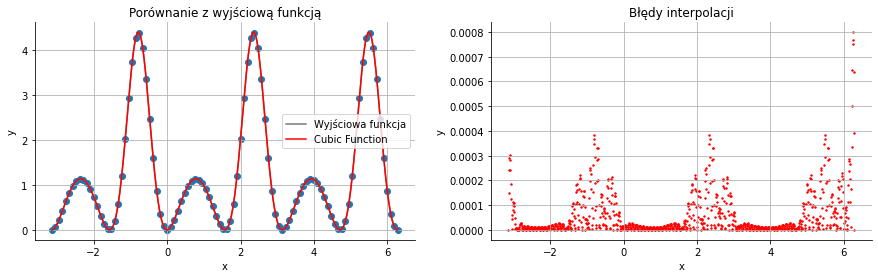

╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Cubic Function │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      0.000799 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                      0.000012 │
╘═════════════════════════════╧═══════════════════════════════╛


In [41]:
n = 100
rich_plot(
    PlotFn(g, "#777", "Wyjściowa funkcja"), 
    [
        PlotIntep(CubicSpline, 'r', 'Cubic Function', kwargs={'boundary_condition': CubicBoundCond.CubicFunction})    
        PlotIntep(CubicSpline, 'r', 'Cubic Function', kwargs={'boundary_condition': CubicBoundCond.CubicFunction})    
    ], 
    a, b, n,
    show_errors_details=True
)

#### Dla $500$ węzłów

Wraz ze wzrostem liczby węzłow, poprawia się dokładność przybliżenia. Widać też znaczne nasilenie się efektu Runge'go dla interpolacji z wykorzystaniem równomiernie rozmieszczonych węzłów.

=================================== Równomierny rozkład punktów ====================================



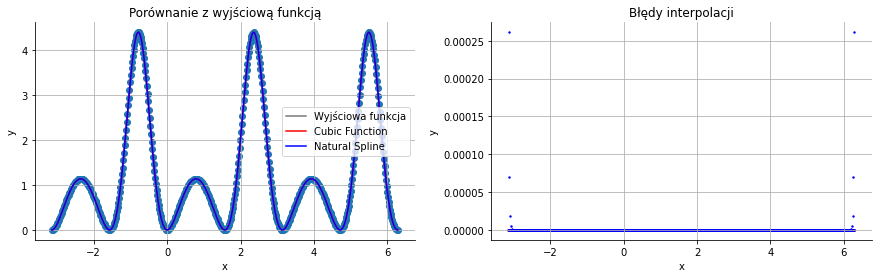

╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Cubic Function │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      0.000001 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                      0.000000 │
╘═════════════════════════════╧═══════════════════════════════╛
╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Natural Spline │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      0.000261 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                      0.000000 │
╘═════════════════════════════╧═══════════════════════════════╛



========================================= Węzły Czebyszewa =========================================


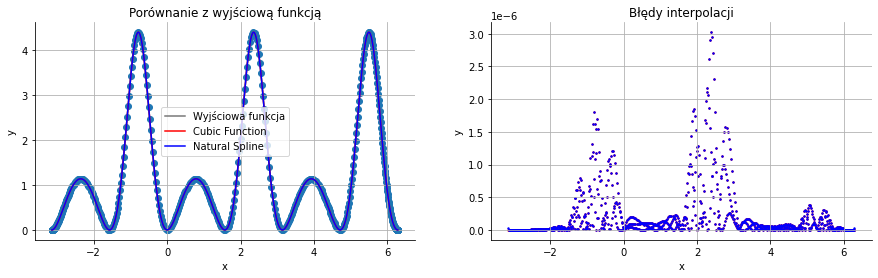

╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Cubic Function │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      0.000003 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                      0.000000 │
╘═════════════════════════════╧═══════════════════════════════╛
╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Natural Spline │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      0.000003 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                      0.000000 │
╘═════════════════════════════╧═══════════════════════════════╛





In [42]:
n = 500
for label, nodes_calc_method in (('Równomierny rozkład punktów', np.linspace), ('Węzły Czebyszewa', chebyshev_nodes)):
    print(f' {label} '.center(100, '='), end='\n\n')
    rich_plot(
        PlotFn(g, "#777", "Wyjściowa funkcja"), 
        [
            PlotIntep(CubicSpline, 'r', 'Cubic Function', kwargs={'boundary_condition': CubicBoundCond.CubicFunction}),
            PlotIntep(CubicSpline, 'b', 'Natural Spline', kwargs={'boundary_condition': CubicBoundCond.NaturalSpline})
        ], 
        a, b, n,
        show_errors_details=True,
        nodes_calc_method=nodes_calc_method
    )
    print('\n\n')

###### Tylko funkcja z warunkiem *Cubic Function*

Znów lepsze przybliżenie osiągamy dla węzłów rozmieszczonych w sposób równomierny.

Rozmieszczenie równomierne:

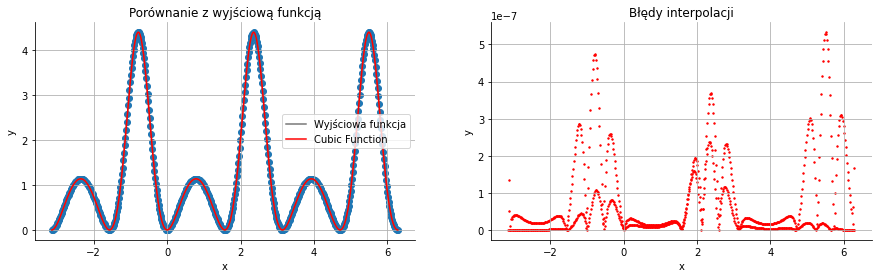

╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Cubic Function │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      0.000001 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                      0.000000 │
╘═════════════════════════════╧═══════════════════════════════╛


In [43]:
n = 500
rich_plot(
    PlotFn(g, "#777", "Wyjściowa funkcja"), 
    [
        PlotIntep(CubicSpline, 'r', 'Cubic Function', kwargs={'boundary_condition': CubicBoundCond.CubicFunction}),
    ], 
    a, b, n,
    show_errors_details=True
)

Rozmieszczenie zgodnie z węzłami Czebyszewa:

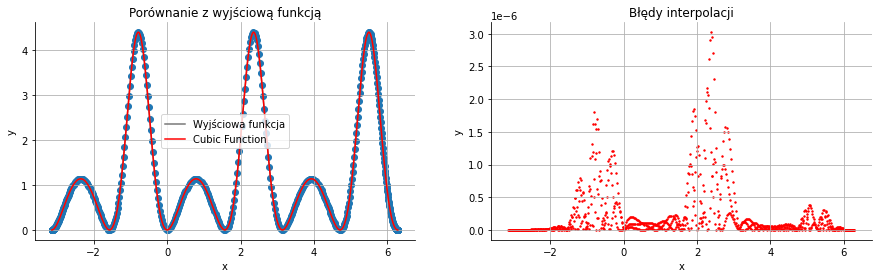

╒═════════════════════════════╤═══════════════════════════════╕
│                             │   Interpolacja Cubic Function │
╞═════════════════════════════╪═══════════════════════════════╡
│ Największy bezwzględny błąd │                      0.000003 │
├─────────────────────────────┼───────────────────────────────┤
│ Suma kwadratów różnic       │                      0.000000 │
╘═════════════════════════════╧═══════════════════════════════╛


In [44]:
n = 500
rich_plot(
    PlotFn(g, "#777", "Wyjściowa funkcja"), 
    [
        PlotIntep(CubicSpline, 'r', 'Cubic Function', kwargs={'boundary_condition': CubicBoundCond.CubicFunction})    
    ], 
    a, b, n,
    show_errors_details=True,
    nodes_calc_method=chebyshev_nodes
)

### Porównanie funkcji sklejanej $2$. i $3$. stopnia

#### Dla $15$ węzłów

Widać bardzo dużą rozbieżność między funkcjami 2. stopnia a funkcjami 3. stopnia.

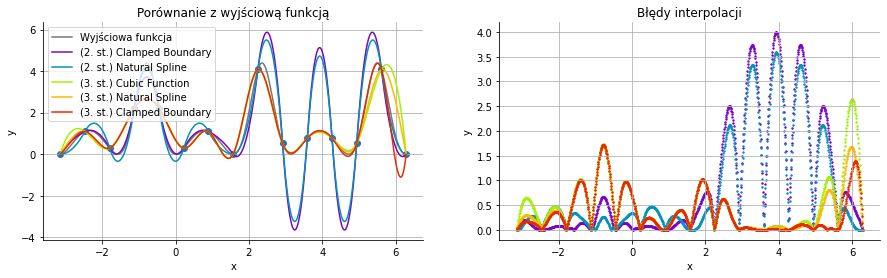

╒═════════════════════════════╤══════════════════════════════════════════╕
│                             │   Interpolacja (2. st.) Clamped Boundary │
╞═════════════════════════════╪══════════════════════════════════════════╡
│ Największy bezwzględny błąd │                                 3.993597 │
├─────────────────────────────┼──────────────────────────────────────────┤
│ Suma kwadratów różnic       │                              2168.106036 │
╘═════════════════════════════╧══════════════════════════════════════════╛
╒═════════════════════════════╤════════════════════════════════════════╕
│                             │   Interpolacja (2. st.) Natural Spline │
╞═════════════════════════════╪════════════════════════════════════════╡
│ Największy bezwzględny błąd │                               3.588034 │
├─────────────────────────────┼────────────────────────────────────────┤
│ Suma kwadratów różnic       │                            1685.008177 │
╘═════════════════════════════╧══════

In [45]:
n = 15
rich_plot(
    PlotFn(g, "#777", "Wyjściowa funkcja"), 
    [
        PlotIntep(QuadraticSpline, '#7A06C3', '(2. st.) Clamped Boundary', kwargs={'boundary_condition': QuadBoundCond.ClampedBoundary}),
        PlotIntep(QuadraticSpline, '#0392BB', '(2. st.) Natural Spline', kwargs={'boundary_condition': QuadBoundCond.NaturalSpline}),
        PlotIntep(CubicSpline, '#A2F300', '(3. st.) Cubic Function', kwargs={'boundary_condition': CubicBoundCond.CubicFunction}),
        PlotIntep(CubicSpline, '#FFB800', '(3. st.) Natural Spline', kwargs={'boundary_condition': CubicBoundCond.NaturalSpline}),
        PlotIntep(CubicSpline, '#E52C00', '(3. st.) Clamped Boundary', kwargs={'boundary_condition': CubicBoundCond.ClampedBoundary})
    ], 
    a, b, n,
    show_errors_details=True
)

#### Dla $35$ węzłów

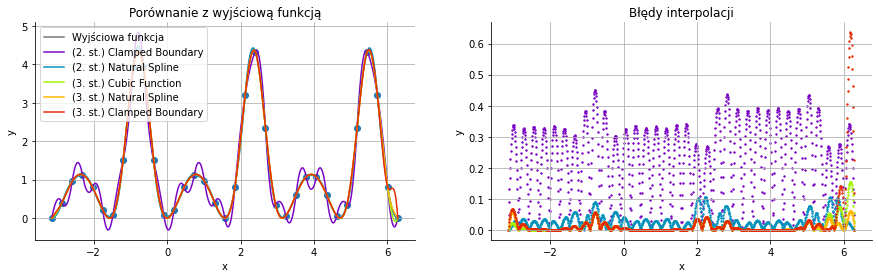

╒═════════════════════════════╤══════════════════════════════════════════╕
│                             │   Interpolacja (2. st.) Clamped Boundary │
╞═════════════════════════════╪══════════════════════════════════════════╡
│ Największy bezwzględny błąd │                                 0.451390 │
├─────────────────────────────┼──────────────────────────────────────────┤
│ Suma kwadratów różnic       │                                66.697220 │
╘═════════════════════════════╧══════════════════════════════════════════╛
╒═════════════════════════════╤════════════════════════════════════════╕
│                             │   Interpolacja (2. st.) Natural Spline │
╞═════════════════════════════╪════════════════════════════════════════╡
│ Największy bezwzględny błąd │                               0.105274 │
├─────────────────────────────┼────────────────────────────────────────┤
│ Suma kwadratów różnic       │                               1.432820 │
╘═════════════════════════════╧══════

In [46]:
n = 35
rich_plot(
    PlotFn(g, "#777", "Wyjściowa funkcja"), 
    [
        PlotIntep(QuadraticSpline, '#7A06C3', '(2. st.) Clamped Boundary', kwargs={'boundary_condition': QuadBoundCond.ClampedBoundary}),
        PlotIntep(QuadraticSpline, '#0392BB', '(2. st.) Natural Spline', kwargs={'boundary_condition': QuadBoundCond.NaturalSpline}),
        PlotIntep(CubicSpline, '#A2F300', '(3. st.) Cubic Function', kwargs={'boundary_condition': CubicBoundCond.CubicFunction}),
        PlotIntep(CubicSpline, '#FFB800', '(3. st.) Natural Spline', kwargs={'boundary_condition': CubicBoundCond.NaturalSpline}),
        PlotIntep(CubicSpline, '#E52C00', '(3. st.) Clamped Boundary', kwargs={'boundary_condition': CubicBoundCond.ClampedBoundary})
    ], 
    a, b, n,
    show_errors_details=True
)

#### Dla $50$ węzłów

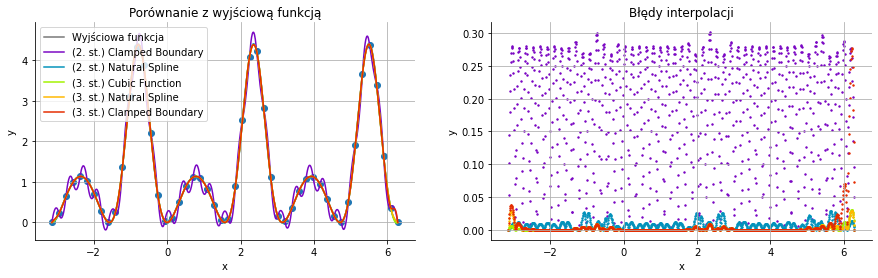

╒═════════════════════════════╤══════════════════════════════════════════╕
│                             │   Interpolacja (2. st.) Clamped Boundary │
╞═════════════════════════════╪══════════════════════════════════════════╡
│ Największy bezwzględny błąd │                                 0.301210 │
├─────────────────────────────┼──────────────────────────────────────────┤
│ Suma kwadratów różnic       │                                41.679781 │
╘═════════════════════════════╧══════════════════════════════════════════╛
╒═════════════════════════════╤════════════════════════════════════════╕
│                             │   Interpolacja (2. st.) Natural Spline │
╞═════════════════════════════╪════════════════════════════════════════╡
│ Największy bezwzględny błąd │                               0.029001 │
├─────────────────────────────┼────────────────────────────────────────┤
│ Suma kwadratów różnic       │                               0.097222 │
╘═════════════════════════════╧══════

In [47]:
n = 50
rich_plot(
    PlotFn(g, "#777", "Wyjściowa funkcja"), 
    [
        PlotIntep(QuadraticSpline, '#7A06C3', '(2. st.) Clamped Boundary', kwargs={'boundary_condition': QuadBoundCond.ClampedBoundary}),
        PlotIntep(QuadraticSpline, '#0392BB', '(2. st.) Natural Spline', kwargs={'boundary_condition': QuadBoundCond.NaturalSpline}),
        PlotIntep(CubicSpline, '#A2F300', '(3. st.) Cubic Function', kwargs={'boundary_condition': CubicBoundCond.CubicFunction}),
        PlotIntep(CubicSpline, '#FFB800', '(3. st.) Natural Spline', kwargs={'boundary_condition': CubicBoundCond.NaturalSpline}),
        PlotIntep(CubicSpline, '#E52C00', '(3. st.) Clamped Boundary', kwargs={'boundary_condition': CubicBoundCond.ClampedBoundary})
    ], 
    a, b, n,
    show_errors_details=True
)

#### Dla $100$ węzłów

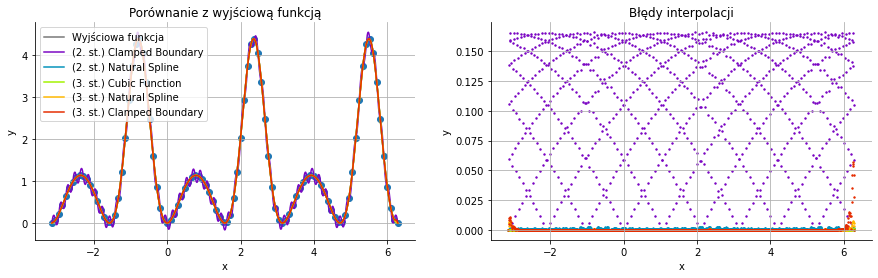

╒═════════════════════════════╤══════════════════════════════════════════╕
│                             │   Interpolacja (2. st.) Clamped Boundary │
╞═════════════════════════════╪══════════════════════════════════════════╡
│ Największy bezwzględny błąd │                                 0.166052 │
├─────────────────────────────┼──────────────────────────────────────────┤
│ Suma kwadratów różnic       │                                14.556447 │
╘═════════════════════════════╧══════════════════════════════════════════╛
╒═════════════════════════════╤════════════════════════════════════════╕
│                             │   Interpolacja (2. st.) Natural Spline │
╞═════════════════════════════╪════════════════════════════════════════╡
│ Największy bezwzględny błąd │                               0.002636 │
├─────────────────────────────┼────────────────────────────────────────┤
│ Suma kwadratów różnic       │                               0.001055 │
╘═════════════════════════════╧══════

In [48]:
n = 100
rich_plot(
    PlotFn(g, "#777", "Wyjściowa funkcja"), 
    [
        PlotIntep(QuadraticSpline, '#7A06C3', '(2. st.) Clamped Boundary', kwargs={'boundary_condition': QuadBoundCond.ClampedBoundary}),
        PlotIntep(QuadraticSpline, '#0392BB', '(2. st.) Natural Spline', kwargs={'boundary_condition': QuadBoundCond.NaturalSpline}),
        PlotIntep(CubicSpline, '#A2F300', '(3. st.) Cubic Function', kwargs={'boundary_condition': CubicBoundCond.CubicFunction}),
        PlotIntep(CubicSpline, '#FFB800', '(3. st.) Natural Spline', kwargs={'boundary_condition': CubicBoundCond.NaturalSpline}),
        PlotIntep(CubicSpline, '#E52C00', '(3. st.) Clamped Boundary', kwargs={'boundary_condition': CubicBoundCond.ClampedBoundary})
    ], 
    a, b, n,
    show_errors_details=True
)

### Dla $500$ węzłów

Co ciekawe, dla 500 węzłów, funkcja 3. stopnia z warunkiem brzegowym *Natural Spline* przybliża gorzej interpolowaną funkcję niż funkcja 2. stopnia, w której również został wykorzystany warunek brzegowy *Natural Spline*. Wciąż jednak najgorzej wypada funkcja 2. stopnia, w której wykorzystany został warunek brzegowy *Clamped Boundary*.

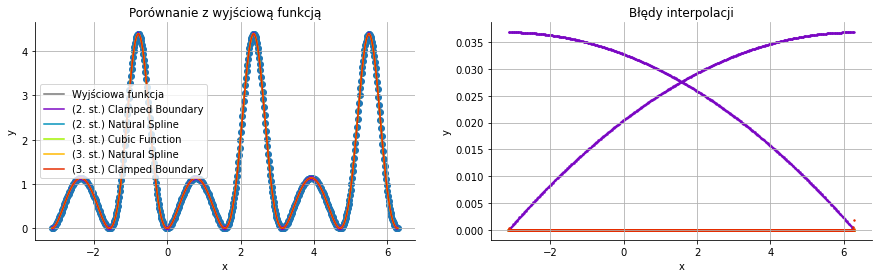

╒═════════════════════════════╤══════════════════════════════════════════╕
│                             │   Interpolacja (2. st.) Clamped Boundary │
╞═════════════════════════════╪══════════════════════════════════════════╡
│ Największy bezwzględny błąd │                                 0.036815 │
├─────────────────────────────┼──────────────────────────────────────────┤
│ Suma kwadratów różnic       │                                 0.722119 │
╘═════════════════════════════╧══════════════════════════════════════════╛
╒═════════════════════════════╤════════════════════════════════════════╕
│                             │   Interpolacja (2. st.) Natural Spline │
╞═════════════════════════════╪════════════════════════════════════════╡
│ Największy bezwzględny błąd │                               0.000019 │
├─────────────────────────────┼────────────────────────────────────────┤
│ Suma kwadratów różnic       │                               0.000000 │
╘═════════════════════════════╧══════

In [49]:
n = 500
rich_plot(
    PlotFn(g, "#777", "Wyjściowa funkcja"), 
    [
        PlotIntep(QuadraticSpline, '#7A06C3', '(2. st.) Clamped Boundary', kwargs={'boundary_condition': QuadBoundCond.ClampedBoundary}),
        PlotIntep(QuadraticSpline, '#0392BB', '(2. st.) Natural Spline', kwargs={'boundary_condition': QuadBoundCond.NaturalSpline}),
        PlotIntep(CubicSpline, '#A2F300', '(3. st.) Cubic Function', kwargs={'boundary_condition': CubicBoundCond.CubicFunction}),
        PlotIntep(CubicSpline, '#FFB800', '(3. st.) Natural Spline', kwargs={'boundary_condition': CubicBoundCond.NaturalSpline}),
        PlotIntep(CubicSpline, '#E52C00', '(3. st.) Clamped Boundary', kwargs={'boundary_condition': CubicBoundCond.ClampedBoundary})
    ], 
    a, b, n,
    show_errors_details=True
)